# Overview of the loopback notebook
The following notebook goes through loopback tests with the QICK RF Board. The RF board has two programmable, 30 dB attenuators for each DAC channel and one programmable, 30 dB attenuator for each ADC channel. Each DAC and ADC channel have a programmable bandpass filter as well. The loopback program can be used to check that the attenuators and filters are operating properly, and generally, for users to familiarize themseleves with the operational characteristics of the RF board. 

**Note: In this demo, we are have 60 dB of in-line attenuation between the DAC and ADC channels in loopback.** 

## Functionality of QICK firmware

The following notebook uses the tProcessorv2 firmware. Some introductory documentation on the software functionality of tProcessorv2 can be found here https://github.com/openquantumhardware/QCE2024/blob/main/demos_firmware/02_qce24.ipynb. 

Introductory documentation for the tProcessorv1 firmware, which as a very similar syntax to v2, and more comprehensive documentation can be found here https://github.com/openquantumhardware/qick/blob/main/qick_demos/00_Send_receive_pulse.ipynb. The loopback program can be used with either version with appropiate syntax.

The functionality of the qick.rfboard subpackage can be found here https://qick-docs.readthedocs.io/latest/_autosummary/qick.rfboard.html.

In [1]:
# jupyter setup boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from tqdm.auto import tqdm

from qick import *
from qick.rfboard import * 
import time

# for now, all the tProc v2 classes need to be individually imported (can't use qick.*)
# the main program class
from qick.asm_v2 import AveragerProgramV2
# for defining sweeps
from qick.asm_v2 import QickSweep1D

In [2]:
# Load bitstream with custom overlay
soc = RFQickSoc216V1('/home/xilinx/jupyter_notebooks/fw/2024-09-28_216_tprocv2r21_rfb_standard/qick_216_rfb.bit', clk_output=None)

soccfg = soc

print(soccfg)

QICK running on ZCU216, software version 0.2.324

Firmware configuration (built Sat Sep 28 20:39:53 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	16 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.838 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 0 is 0_228, on JHC1
	1:	axis_signal_gen_v6 - envelope memory 16384 samples (1.709 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 1 is 1_228, on JHC2
	2:	axis_signal_gen_v6 - envelope memory 32768 samples (3.419 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 2 is 2_228, on JHC1
	3:	axis_signal_gen_v6 - envelope memory 16384 samples (1.709 us)
		fs=9584.640 MHz, fabric=599.040 MHz, 32-bit DDS, range=9584.640 MHz
		DAC tile 0, blk 3 is 3_228, on JHC2
	4:	axis_sg_mixmux8_v1 - envelope memory 0 samples (0.000 us)
		fs=6881.280 MHz, fabric=430.080 MHz, 

## Hardware Configuration
To test the RF Board in loopback connect one DAC channel to one ADC channel. A look up table for port mapping between RF216 ports and ZCU216 can be found here: https://github.com/openquantumhardware/qick/wiki/RF216-(RF-board-for-ZCU216). 

To run QICK programs, we need to know the DAC (generator) and ADC (readout) channels **as labeled in the QICK firmware**.

In ths demo, we have DAC channel 1_229 (5 on the RF board pinout) connected to ADC channel 0_226 (4 on the RF board pinout). To figure out what these correspond to in the QICK firmware, we can build a lookup table using the following cells:

In [3]:
for iCard, card in enumerate(soc.dac_cards):
    if card is None:
        print("DAC card %d: empty"%(iCard))
    elif isinstance(card, DacDcCard216):
        print("DAC card %d: DC"%(iCard), card.chains)
    elif isinstance(card, DacRfCard216):
        print("DAC card %d: RF"%(iCard))
        print("filters:", [chain.read_filter("CHIPTYPE") for chain in card.chains])

for iCard, card in enumerate(soc.adc_cards):
    if card is None:
        print("ADC card %d: empty"%(iCard))
    elif isinstance(card, AdcDcCard216):
        print("ADC card %d: DC??"%(iCard), card.chains)
    elif isinstance(card, AdcRfCard216):
        print("ADC card %d: RF"%(iCard))
        print("filters:", [chain.read_filter("CHIPTYPE") for chain in card.chains])

DAC card 0: empty
DAC card 1: RF
filters: [1, 1, 1, 1]
DAC card 2: empty
DAC card 3: empty
ADC card 0: empty
ADC card 1: empty
ADC card 2: RF
filters: [1, 1]
ADC card 3: empty


In [26]:
for i, gen in enumerate(soc.gens):
    if gen.rfb_ch != None:
        print("DAC Channel in QICK firmware:",i)
    if isinstance(gen.rfb_ch, Chain216):
        print("Corresponding Channel on RF board pinout:",gen.rfb_ch.global_ch,"\n")

DAC Channel in QICK firmware: 4
Corresponding Channel on RF board pinout: 4 

DAC Channel in QICK firmware: 5
Corresponding Channel on RF board pinout: 5 

DAC Channel in QICK firmware: 6
Corresponding Channel on RF board pinout: 6 

DAC Channel in QICK firmware: 7
Corresponding Channel on RF board pinout: 7 



In [25]:
for i, buf in enumerate(soc.avg_bufs):
    if buf.rfb_ch != None:
        print("ADC Channel in QICK firmware:",i)
    if isinstance(buf.rfb_ch, Chain216):
        print("Corresponding Channel on RF board pinout:",buf.rfb_ch.global_ch,"\n")

ADC Channel in QICK firmware: 0
Corresponding Channel on RF board pinout: 4 

ADC Channel in QICK firmware: 2
Corresponding Channel on RF board pinout: 5 

ADC Channel in QICK firmware: 3
Corresponding Channel on RF board pinout: 5 

ADC Channel in QICK firmware: 4
Corresponding Channel on RF board pinout: 5 

ADC Channel in QICK firmware: 5
Corresponding Channel on RF board pinout: 5 

ADC Channel in QICK firmware: 6
Corresponding Channel on RF board pinout: 5 

ADC Channel in QICK firmware: 7
Corresponding Channel on RF board pinout: 5 

ADC Channel in QICK firmware: 8
Corresponding Channel on RF board pinout: 5 

ADC Channel in QICK firmware: 9
Corresponding Channel on RF board pinout: 5 



In [16]:
for card_num in range(8):
    soc.board_sel.enable(board_id=card_num)                             
    if card_num<4: # DAC
        gpio = GpioMCP23S08(soc.filter_spi, ch_en=4, dev_addr=0, iodir=0xf0)
    else: # ADC
        gpio = GpioMCP23S08(soc.filter_spi, ch_en=2, dev_addr=0, iodir=0xf0)
    card_id = gpio.read_reg("GPIO_REG") >> 4                             
    print("card %d: ID %d"%(card_num, card_id))

card 0: ID 15
card 1: ID 3
card 2: ID 15
card 3: ID 15
card 4: ID 15
card 5: ID 15
card 6: ID 2
card 7: ID 15


## Building the channel look up table:

Looking at the cells above, we see that DAC Channel 5 on the pinout corresponds to channel 5 in the QICK firmware and ADC channel 4 on the pinout corresponds to channel 0 in the QICK firmware. We can use these to build a convenient look up as below:

<br>

<center> DAC (generator) PORT number Mapping </center>

|Port Number|RF Board Pinout|QICK Firmware|
|:---:|:---:|:---:|
|1_229|5|5|

<br>
<br>

<center> ADC (readout) PORT number Mapping </center>

|Port Number|RF Board Pinout|QICK Firmware|
|:---:|:---:|:---:|
|0_226|4|0|

<br>

Now we use the channels as defined in the QICK firmware to run the rest of the notebook:

In [28]:
# define DAC and ADC ports as defined in the QICK firmware
GEN_CH=5 # DAC 
RO_CH=0  # ADC

## Bias DACs
The RF board has 8 bias DACs. We can set the voltage on a given bias channel with ```rfb_set_bias({bias channel},{voltage})```. The channels are labeled 0 through 7 and the voltage can be set from -10 to 10 V. We can check the voltage setpoint of a given channel using ```rfb_get_bias({bias channel})```.

In [31]:
print("read bias:", soc.rfb_get_bias(0))
print("set bias:", soc.rfb_set_bias(0, 1.0))
print("read bias:", soc.rfb_get_bias(0))

read bias: 0.0
set bias: 1.0000038146972656
read bias: 1.0000038146972656


## Loopback program
The cell below defines the loopback program used throughout the notebook to test the attenuators and filters.

In [29]:
class LoopbackProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], mixer_freq=cfg['mixer_freq'], ro_ch=ro_ch)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro",
                               freq=cfg['freq'],
                               gen_ch=gen_ch,
                               outsel='product')
        self.add_cosine(ch=gen_ch, name="ramp", length=cfg['ramp_len'], even_length=True)
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch,
                       style="const",
#                        style="flat_top", 
#                        envelope="ramp", 
                       freq=cfg['freq'],
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'],
                      )
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
    def _body(self, cfg):
        self.delay_auto()
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0.0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], mr=True)


## Testing the programmable attenuators

The two programmable 30 dB attenuators on the DAC side are adjusted using:

```rfb_set_gen_rf({DAC Channel},{first attenuator dB}, {second attenuator dB})```

and the programmable 30 dB attenuator on the ADC side similarly adjusted using:

```rfb_set_ro_rf({ADC Channel}, {attenuator dB})```

The cell below plots the I/Q components of the signal. By adjusting the programmable attenuators, we should find that decreasing the attenuation on either the ADC or DAC sides will result in larger I/Q amplitudes, and conversely, increasing the attenuation will result in decreased amplitudes.

  0%|          | 0/100 [00:00<?, ?it/s]

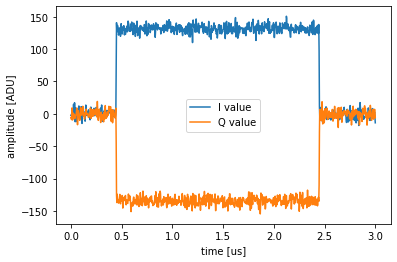

In [30]:
config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'mixer_freq': 3500,
          'freq': 4000,
          'nqz': 2,
          'trig_time': 0.0,
          'ro_len': 3.0,
          'flat_len': 2.0,
          'ramp_len': 1.0,
          'phase': 0,
          'gain': 1.0
         }

prog = LoopbackProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
freq = config['freq']
soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bandpass', bw=1.0)
soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bandpass', bw=1.0)
# Set attenuator on DAC.
soc.rfb_set_gen_rf(config['gen_ch'], 5, 15)
# Set attenuator on ADC.
soc.rfb_set_ro_rf(config['ro_ch'], 30)

iq_list = prog.acquire_decimated(soc, soft_avgs=100)
t = prog.get_time_axis(ro_index=0)
iq = iq_list[0]
plt.plot(t, iq[:,0], label="I value")
plt.plot(t, iq[:,1], label="Q value")
plt.legend()
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");

## Frequency Sweeping
Below we define the ```FreqSweepProgram``` class to sweep through pulses at different frequencies. In the configuration dictionary below, we can the set ```'steps'``` (integer-valued) and ```'freqs' = QickSweep1D("myloop", {start frequency}, {end frequency})```. The ```FreqSweepProgram``` object will then sweep through the frequency range defined in ```QickSweep1D()``` in the given number of defined steps.

As shown belown attenuation increases with frequnecy.

  0%|          | 0/100 [00:00<?, ?it/s]

Text(0.5, 1.0, 'I/Q Magnitude at different frequencies')

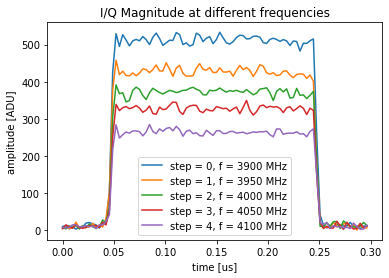

In [116]:
class FreqSweepProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], mixer_freq=cfg['mixer_freq'], ro_ch=ro_ch)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])

        self.add_loop("myloop", self.cfg["steps"])
        self.add_readoutconfig(ch=ro_ch, name="myro", freq=cfg['freq'], gen_ch=gen_ch)

        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch, 
                       style="const", 
                       freq=cfg['freq'], 
                       length=cfg['pulse_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'], 
                      )
        
    def _body(self, cfg):
        # if you delay the config by too long, you can see the readout get reconfigured in the middle of your pulse
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'])

# do a sweep with 5 points and plot decimated
steps = 5
start_freq = 3900
end_freq = 4100
config = {'steps': steps,
          'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'freq': QickSweep1D("myloop", start_freq, end_freq),
          'mixer_freq': 4000,
          'nqz': 2,
          'trig_time': 0.4,
          'ro_len': 0.3,
          'pulse_len': 0.2,
          'phase': 0,
          'gain': 1.0
         }

freq = config['mixer_freq']
soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bandpass', bw=1.0)
soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bandpass', bw=1.0)
# Set attenuator on DAC.
soc.rfb_set_gen_rf(config['gen_ch'], 5, 15)
# Set attenuator on ADC.
soc.rfb_set_ro_rf(config['ro_ch'], 30)



prog = FreqSweepProgram(soccfg, reps=1, final_delay=0.5, cfg=config)

iq_list = prog.acquire_decimated(soc, soft_avgs=100)
t = prog.get_time_axis(ro_index=0)

sweep_freqs = np.linspace(start_freq,end_freq,steps)
for ii, iq in enumerate(iq_list[0]):
    plt.plot(t, np.abs(iq.dot([1,1j])), label="step = {}, f = {} MHz".format(ii,int(sweep_freqs[ii])))
    
plt.legend()
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");
plt.title("I/Q Magnitude at different frequencies")

## Transmission efficiency
The function below calculates the forward transmission coefficient ($S_{21}$) between the DAC and ADC channels. Measuring $S_{21}$ in loopback is useful to understand the attenuation and optimal operating frequencies of the RF board.

In [117]:
def measure_s21(gen_ch, ro_ch, nqz, gain, steps=101, dds_range=0.45, overlap=0, plot=False, progress=True):
    config = {'steps': steps,
              'gen_ch': gen_ch,
              'ro_ch': ro_ch,
              'nqz': nqz,
              'trig_time': 0.4,
              'pulse_len': 10.0,
              'ro_len': 10.1,
              'phase': 0,
              'gain': gain
             }
    allfreqs = []
    allpowers = []
    f_dds = soccfg['gens'][gen_ch]['f_dds']
    mixer_freqs = np.arange(0.5, 10000/f_dds, dds_range*2-overlap)*f_dds    
    for i, mixer_freq in enumerate(tqdm(mixer_freqs, disable=not progress)):
        config['mixer_freq'] = mixer_freq
        config['freq'] = QickSweep1D("myloop", mixer_freq-dds_range*f_dds, mixer_freq+dds_range*f_dds)

        prog = FreqSweepProgram(soccfg, reps=10, final_delay=1.0, cfg=config)
        freqs = prog.get_pulse_param('myro', 'freq', as_array=True)
        iq_list = prog.acquire(soc, soft_avgs=1, progress=False)
        iq_complex = iq_list[0][0].dot([1,1j])
        
        mags = np.abs(iq_complex)
        powers = 20*np.log10(mags)
        allfreqs.append(freqs)
        allpowers.append(powers)
        if plot:
            plt.plot(freqs, powers, label="mixer_freq=%f"%(mixer_freq))
        #     plt.plot(freqs, mags, label="RO filter BW %.2f GHz"%(ro_bw))
            plt.ylabel("S21 [arb. dB]")
            plt.xlabel("Frequency [MHz]")
    allfreqs = np.array(allfreqs).flatten()
    allpowers = np.array(allpowers).flatten()
    return allfreqs, allpowers

## $S_{21}$ vs Frequency 

The following cell plots the $S_{21}$ as a function of the sweeping frequency. We can see that the RF board has a clear range at which the transmittance is optimized and generally that there is greater attenuation at higher frequencies as expected.

  0%|          | 0/7 [00:00<?, ?it/s]

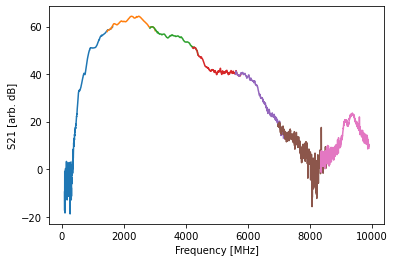

In [119]:
soc.rfb_set_gen_rf(GEN_CH, 5, 15)
soc.rfb_set_ro_rf(RO_CH, 30)
soc.rfb_set_gen_filter(GEN_CH, fc=0, ftype='bypass')
soc.rfb_set_ro_filter(RO_CH, fc=0, ftype='bypass')
measure_s21(GEN_CH,RO_CH,2,1.0,steps=501,dds_range=0.45,overlap=0.1,plot=True);

## $S_{21}$ at different Nyquist zones

The RF board can be adjusted to have maximized transmittance in different Nyquist zones. As shown below, transmittance can be optimized at lower frequencies $\le f_s/2$ (e.g., the first Nyquist zone) by using nqz = 1 or at higher frequencies $\ge f_s/2$ (e.g., the second Nyquist zone) using nqz = 2. 

Adjusting the Nyquist zones can be useful to minimize attenuation based on the frequency of the incident pulse one is sending.

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

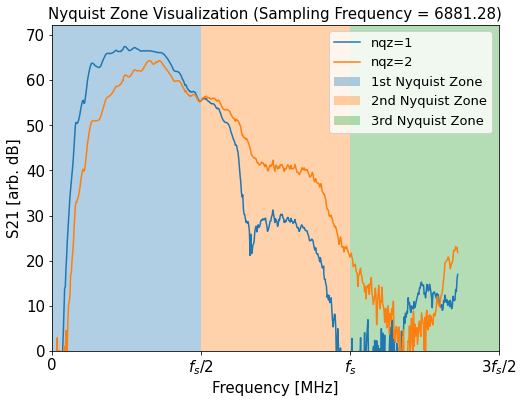

In [120]:
# set attenuators and filters
soc.rfb_set_gen_rf(GEN_CH, 5, 15)
soc.rfb_set_ro_rf(RO_CH, 30)
soc.rfb_set_gen_filter(GEN_CH, fc=0, ftype='bypass')
soc.rfb_set_ro_filter(RO_CH, fc=0, ftype='bypass')

fig,ax = plt.subplots(figsize = (8,6))
plt.plot(*measure_s21(GEN_CH,RO_CH,nqz = 1,gain = 1.0), label="nqz=1")
plt.plot(*measure_s21(GEN_CH,RO_CH,nqz = 2,gain = 1.0), label="nqz=2")
plt.ylim(bottom=0)
ylims = ax.get_ylim()
xlims = ax.get_xlim()

## visualizing the Nyquist zones ##
fs_dac = 6881.280 # sampling speed of the DAC
nyquist_zones = ["1st Nyquist Zone","2nd Nyquist Zone","3rd Nyquist Zone"]
for nindex in range(len(nyquist_zones)):
    zone = nindex*fs_dac/2
    ax.fill_between([zone,zone + fs_dac/2],min(ylims),max(ylims),label = nyquist_zones[nindex],alpha = 0.35)

ax.set_ylim(ylims[0],ylims[1]) # just for aesthetics.
ax.set_xlim(0,3/2 * fs_dac)
ax.set_xticks(np.arange(0,1.51*fs_dac,fs_dac/2),["0",r"$f_s/2$",r"$f_s$",r"$3f_s/2$"],fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.ylabel("S21 [arb. dB]",fontsize = 15)
plt.xlabel("Frequency [MHz]",fontsize = 15)
plt.title("Nyquist Zone Visualization (Sampling Frequency = {})".format(fs_dac),fontsize = 15)
plt.legend(fontsize = 13);

## Filtering with the RF Board

Each DAC and ADC channel has one programmable filter based on Analog Devices' ADMV8818-EP MMIC. The ADMV8818-EP is comprised of four high-pass filters and low-pass filters (see the schematic below) that can be controlled independently for customizable signal filtering including bandpass filtering. On each side of the chip, there is also a bypass configuration allowing for pure low-pass or high-pass filtering.

<div style="text-align: center;">
    <img src="Figures/ADMV8818-EP-schematic.png" alt="alt text" width="350">
</div>

The numbering of the filters increases with 3dB cut-off frequency. For instance LPF 1 has the smallest 3dB cut-off frequency while LPF 4 has the highest. Similarly, HPF 1 has the smallest 3dB cut-off frequency out of the HPFs and HPF 4 has the highest. 

Each LP and HP filter has four 4-bit tunable capacitors allowing for each to take 16 different "states". The states scale with with 3dB cut-off frequency similar to the filter numbering. That is state 0 for either a LP or HP filter corresponds with the the smallest 3dB cut-off frequency for that given filter while state 16 corresponds with the highest. More information on the ADMV8818-EP from Analog Devices can be found here https://www.analog.com/media/en/technical-documentation/data-sheets/admv8818-ep.pdf. 


Below we demonstrate how to tune these filters in the QICK firmware:

## Low-pass and high-pass filtering functionality
Below we define the function ```set_filter()``` to employ low-pass and high-pass filtering. The ```lpf``` and ```hpf``` parameters can be used to select the filter we want to use (take values 0, 1, 2, 3, or 4). Setting ```lpf``` and ```hpf``` to 0 is the bypass configuration. The parameter ```state``` is used to select the state of the selected filters. 

In [121]:
# just to be sure we're doing things right, set registers directly
def set_filter(gen_ch, ro_ch, lpf, hpf, state=0): 
    sw = 0xc0 + (hpf<<3) + lpf
    filt_bits = (state<<4) + state
    rfb_ch = soc.gens[gen_ch].rfb
    rfb_ch.brd_sel.enable(rfb_ch.rfboard_ch)
    rfb_ch.filter.reg_wr('WR0_SW', sw)
    rfb_ch.filter.reg_wr('WR0_FILTER', filt_bits)
    rfb_ch.brd_sel.disable()

    rfb_ch = soc.avg_bufs[ro_ch].rfb
    rfb_ch.brd_sel.enable(rfb_ch.rfboard_ch)
    rfb_ch.filter.reg_wr('WR0_SW', sw)
    rfb_ch.filter.reg_wr('WR0_FILTER', filt_bits)
    rfb_ch.brd_sel.disable()

## Low-pass filtering

### The four low-pass filters in state 0
Below we illustrate switching between the four low-pass filters. We set ```hpf=0``` so we only get LPF. Also note that ```ftype``` in ```rfb_set_gen_filter()``` and ```rfb_set_ro_filter()``` is set to 'bypass' when we want to employ purely low-pass or high-pass filtering.

  0%|          | 0/5 [00:00<?, ?it/s]

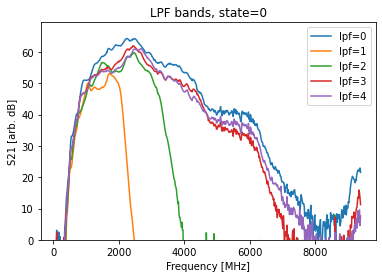

In [51]:
soc.rfb_set_gen_rf(GEN_CH, 5, 15)
soc.rfb_set_ro_rf(RO_CH, 30)
soc.rfb_set_gen_filter(GEN_CH, fc=0, ftype='bypass')
soc.rfb_set_ro_filter(RO_CH, fc=0, ftype='bypass')

for lpf in tqdm(range(0,5)):
    set_filter(GEN_CH, RO_CH, lpf, 0, 0)

    plt.plot(*measure_s21(GEN_CH,RO_CH,2,1.0, progress=False), label="lpf=%d"%(lpf))
plt.ylabel("S21 [arb. dB]")
plt.xlabel("Frequency [MHz]")
plt.ylim(bottom=0)
plt.title("LPF bands, state=0")
plt.legend();

### Low-pass filtering at different states
Here we use low-pass filter 2 (```lpf=2```) and loop through its different states.

  0%|          | 0/16 [00:00<?, ?it/s]

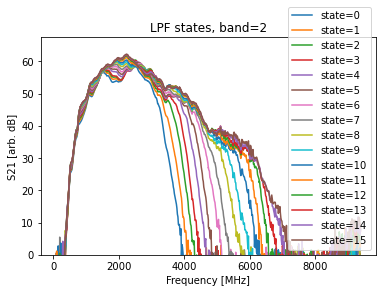

In [52]:
soc.rfb_set_gen_rf(GEN_CH, 5, 15)
soc.rfb_set_ro_rf(RO_CH, 30)
soc.rfb_set_gen_filter(GEN_CH, fc=0, ftype='bypass')
soc.rfb_set_ro_filter(RO_CH, fc=0, ftype='bypass')

for state in tqdm(range(0,16)):
    set_filter(GEN_CH, RO_CH, 2, 0, state)

    plt.plot(*measure_s21(GEN_CH,RO_CH,2,1.0, progress=False), label="state=%d"%(state))
plt.ylabel("S21 [arb. dB]")
plt.xlabel("Frequency [MHz]")
plt.ylim(bottom=0)
plt.title("LPF states, band=2")
plt.legend();

## High-pass filtering

### The four high-pass filters in state 0
Below we illustrate switching between the four high-pass filters. We set ```lpf=0```.

  0%|          | 0/5 [00:00<?, ?it/s]

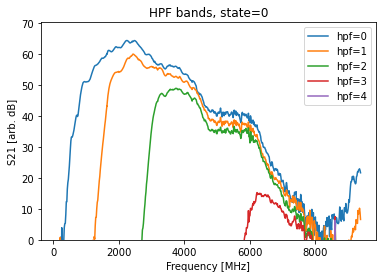

In [53]:
soc.rfb_set_gen_rf(GEN_CH, 5, 15)
soc.rfb_set_ro_rf(RO_CH, 30)
soc.rfb_set_gen_filter(GEN_CH, fc=0, ftype='bypass')
soc.rfb_set_ro_filter(RO_CH, fc=0, ftype='bypass')

for hpf in tqdm(range(0,5)):
    set_filter(GEN_CH, RO_CH, 0, hpf, 0)

    plt.plot(*measure_s21(GEN_CH,RO_CH,2,1.0, progress=False), label="hpf=%d"%(hpf))
plt.ylabel("S21 [arb. dB]")
plt.xlabel("Frequency [MHz]")
plt.ylim(bottom=0)
plt.title("HPF bands, state=0")
plt.legend();

### High-pass filtering at different states
Here we use high-pass filter 2 (```hpf=2```) and loop through its different states.

  0%|          | 0/16 [00:00<?, ?it/s]

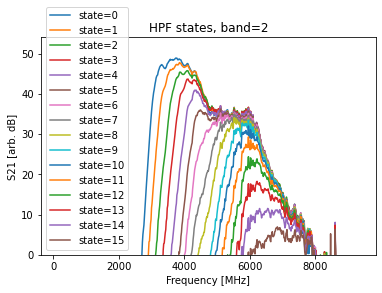

In [54]:
soc.rfb_set_gen_rf(GEN_CH, 5, 15)
soc.rfb_set_ro_rf(RO_CH, 30)
soc.rfb_set_gen_filter(GEN_CH, fc=0, ftype='bypass')
soc.rfb_set_ro_filter(RO_CH, fc=0, ftype='bypass')

for state in tqdm(range(0,16)):
    set_filter(GEN_CH, RO_CH, 0, 2, state)

    plt.plot(*measure_s21(GEN_CH,RO_CH,2,1.0, progress=False), label="state=%d"%(state))
plt.ylabel("S21 [arb. dB]")
plt.xlabel("Frequency [MHz]")
plt.ylim(bottom=0)
plt.title("HPF states, band=2")
plt.legend();

## Bandpass filtering 
We can employ bandpass filtering by setting ```ftype = 'bandpass'``` in ```rfb_set_gen_filter()``` and ```rfb_set_ro_filter()```. The paramter ```fc``` sets the frequency center of the passband and ```bw``` sets the bandwidth.

**Mention base attenuation after checking on computer it works as you think**

  0%|          | 0/5 [00:00<?, ?it/s]

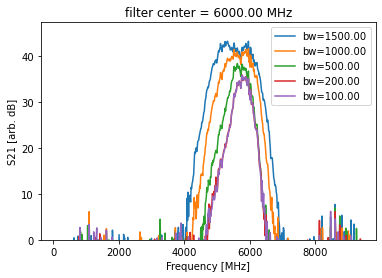

In [83]:
soc.rfb_set_gen_rf(GEN_CH, 5, 15)
soc.rfb_set_ro_rf(RO_CH, 30)
freq = 6000
for bw in tqdm([1500, 1000, 500, 200, 100]):

    soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bandpass', bw=bw/1000)
    soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bandpass', bw=bw/1000)

    plt.plot(*measure_s21(GEN_CH,RO_CH,2,1.0, progress=False), label="bw=%.2f"%(bw))
    
plt.ylabel("S21 [arb. dB]")
plt.xlabel("Frequency [MHz]")
plt.ylim(bottom=0)
plt.title("filter center = %.2f MHz"%(freq));
plt.legend();

## Testing Saturation in Loopback

If the ZCU216 recieves too large of a pulse, it can cause it to saturate. When the ZCU216 saturates, it will raise an "interrupt" and will then automatically turn on its built-in attenuators to add an additional 15 dB of attenuation, which can degrade the signal integrity. The current iteration of the RF board adds 60-90 dB of gain, so saturation can quickly become an issue without enough external attenuation.

The following cells can be used to check if the ZCU216 is saturating. The main function is ```clear_interupts()```. As implied by its name it clears and then prints out the interrupts raised by the ZCU216. It can sometimes take several passes to clear an interrupt. 

There are two significant interrupts to look for when it comes to saturation: ```XRFDC_ADC_OVR_RANGE_MASK``` and ```XRFDC_ADC_OVR_VOLTAGE_MASK```. 

```XRFDC_ADC_OVR_RANGE_MASK```: warns that the ADC units (ADU) have reached their maximum possible value (e.g., the highest possible counts that can be read in the QICK firmware). This interrupt on its own will **not** cause the ZCU216 to add 15 dB of attenuation. 


```XRFDC_ADC_OVR_VOLTAGE_MASK```: warns that the the input voltage is outside of the ADC safe range (e.g., the ZCU216 has recieved too much voltage). **This will cause the ZCU216 to add 15 dB more attenuation.**

In [64]:
import xrfdc

# 0x0000F000 is only used by DAC, I think
# 0x03000000 is not used?
# https://docs.amd.com/r/en-US/pg269-rf-data-converter/XRFdc_IntrEnable
# https://docs.amd.com/r/en-US/pg269-rf-data-converter/Interrupt-Handling
# https://github.com/Xilinx/embeddedsw/blob/master/XilinxProcessorIPLib/drivers/rfdc/src/xrfdc_hw.h

def clear_interrupts(soc, verbose=False):
    interrupt_masks = [
        (0x0000000F, "XRFDC_IXR_FIFOUSRDAT_MASK"), # FIFO over/underflow, linked to XRFDC_ADC_FIFO_OVR_MASK?
        (0x00000FF0, "XRFDC_ADC_IXR_DATAPATH_MASK"), # overflow/saturation in datapath (e.g. decimation), linked to XRFDC_ADC_DAT_OVR_MASK?
        (0x00FF0000, "XRFDC_SUBADC_IXR_DCDR_MASK"), # analog input over/under full-scale range for individual sub-ADCs, linked to OVR_RANGE interrupt
        (0x04000000, "XRFDC_ADC_OVR_VOLTAGE_MASK"), # analog input exceeding ADC safe range - gen3 RFSoC
        (0x08000000, "XRFDC_ADC_OVR_RANGE_MASK"), # analog input exceeding ADC full-scale range
        (0x10000000, "XRFDC_ADC_CMODE_OVR_MASK"), # analog input common-mode voltage above spec - gen3 RFSoC
        (0x20000000, "XRFDC_ADC_CMODE_UNDR_MASK"), # analog input common-mode voltage below spec - gen3 RFSoC
        (0x40000000, "XRFDC_ADC_DAT_OVR_MASK"),
        (0x80000000, "XRFDC_ADC_FIFO_OVR_MASK"),
    ]
    arr = xrfdc._ffi.new("unsigned int [1]")
    allclear = False
    attempts = 0
    maxattempts = 5
    while not allclear:
        allclear = True
        for name, cfg in soc['adcs'].items():
            tile, block = cfg['index']
            status = xrfdc._lib.XRFdc_GetIntrStatus(soc.rf._instance, xrfdc._lib.XRFDC_ADC_TILE,tile,block,arr)
            if status != 0: print("error in reading interrupts:", status)
            interrupts = arr[0]
            if interrupts != 0:
                allclear = False
                names = []
                for mask, name in interrupt_masks:
                    if (mask & interrupts) != 0:
                        interrupts &= 0xFFFFFFFF - mask
                        names.append(name)
                if interrupts != 0: print("unrecognized interrupts:", interrupts)
                if verbose or attempts == 0:
                    print("pass %d, interrupts on tile %d block %d:"%(attempts, tile, block), hex(arr[0]), names)
                status = xrfdc._lib.XRFdc_IntrClr(soc.rf._instance, xrfdc._lib.XRFDC_ADC_TILE,tile,block,0xffffffff)
                if status != 0: print("error in clearing interrupts:", status)
        attempts += 1
        if attempts >= maxattempts:
            print("giving up")
            break
    if attempts > 1 and attempts < maxattempts:
        print("successfully cleared all interrupts in %d attempts"%(attempts-1))

# just used to print out set attenuation 
def print_attenuator(soc, ro_ch):
    tile, block = [int(x) for x in soc['readouts'][ro_ch]['adc']]
    adc = soc.rf.adc_tiles[tile].blocks[block]
    print(adc.DSA)
    
def set_attenuator(soc, ro_ch, val, verbose=False):
    tile, block = [int(x) for x in soc['readouts'][ro_ch]['adc']]
    adc = soc.rf.adc_tiles[tile].blocks[block]
    if verbose: print("before:", adc.DSA)
    adc.DSA['Attenuation'] = val
    if verbose: print("after:", adc.DSA)

set DAC attenuators: None
set ADC attenuators: None


  0%|          | 0/1 [00:00<?, ?it/s]

{'DisableRTS': 0, 'Attenuation': 0.0}
pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 0, interrupts on tile 2 block 1: 0x6cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK', 'XRFDC_ADC_DAT_OVR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24000000 ['XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 1: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 2, interrupts on tile 2 block 1: 0x48ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_DAT_OVR_MASK']
pass 3, interrupts on tile 2 block 1: 0x48ff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_DAT_OVR_MASK']
pass 4, interrupts on tile 2 block 1: 0x48ff0000 ['XRFDC_S

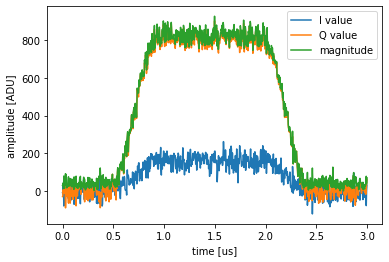

In [65]:
class LoopbackProgram(AveragerProgramV2):
    def _initialize(self, cfg):
        ro_ch = cfg['ro_ch']
        gen_ch = cfg['gen_ch']
        self.declare_gen(ch=gen_ch, nqz=cfg['nqz'], mixer_freq=cfg['mixer_freq'], ro_ch=ro_ch)
        self.declare_readout(ch=ro_ch, length=cfg['ro_len'])
        self.add_readoutconfig(ch=ro_ch, name="myro",
                               freq=cfg['freq'],
                               gen_ch=gen_ch,
                               outsel='product')
        self.add_cosine(ch=gen_ch, name="ramp", length=cfg['ramp_len'], even_length=True)
        self.add_pulse(ch=gen_ch, name="mypulse", ro_ch=ro_ch,
#                        style="const",
                       style="flat_top", 
                       envelope="ramp", 
                       freq=cfg['freq'],
                       length=cfg['flat_len'],
                       phase=cfg['phase'],
                       gain=cfg['gain'],
                      )
        self.send_readoutconfig(ch=cfg['ro_ch'], name="myro", t=0)
    def _body(self, cfg):
        self.delay_auto()
        self.pulse(ch=cfg['gen_ch'], name="mypulse", t=0.0)
        self.trigger(ros=[cfg['ro_ch']], pins=[0], t=cfg['trig_time'], mr=True)

config = {'gen_ch': GEN_CH,
          'ro_ch': RO_CH,
          'mixer_freq': 3000,
          'freq': 3000,
          'nqz': 1,
          'trig_time': 0.0,
          'ro_len': 3.0,
          'flat_len': 1.0,
          'ramp_len': 1.0,
          'phase': 0,
          'gain': 1.0
         }
prog = LoopbackProgram(soccfg, reps=1, final_delay=0.5, cfg=config)
freq = config['freq']
soc.rfb_set_gen_filter(config['gen_ch'], fc=freq/1000, ftype='bandpass', bw=1.0)
soc.rfb_set_ro_filter(config['ro_ch'], fc=freq/1000, ftype='bandpass', bw=1.0)
set_attenuator(soc, RO_CH, 0)

print("set DAC attenuators:", soc.rfb_set_gen_rf(config['gen_ch'], 0, 10))
print("set ADC attenuators:", soc.rfb_set_ro_rf(config['ro_ch'], 25))

# clear_interrupts(soc)
iq_list = prog.acquire_decimated(soc, soft_avgs=1)
print_attenuator(soc, RO_CH)
clear_interrupts(soc, verbose=True)

t = prog.get_time_axis(ro_index=0)
iq = iq_list[0]
plt.plot(t, iq[:,0], label="I value")
plt.plot(t, iq[:,1], label="Q value")
plt.plot(t, np.abs(iq.dot((1,1j))), label="magnitude")
plt.legend()
plt.ylabel("amplitude [ADU]")
plt.xlabel("time [us]");

The above test was done with 60 dB of attenuation between the DAC and ADC. Notice that above we did not encounter either ```XRFDC_ADC_OVR_RANGE_MASK``` or ```XRFDC_ADC_OVR_VOLTAGE_MASK``` interrupts and I/Q vs Time has super-gaussian profile as expected from loopback. So here we did not cause the ZCU216 to saturate and hence it did not add more attenuation.

As an example of what saturation will actually look like - in an earlier test done with only 40 dB of attenuation between the DAC and ADC channels we get the following output from running the same code block:

```set DAC attenuators: (0.0, 10.0)
set ADC attenuators: 25.0
(0%|          | 0/1 [00:00<?, ?it/s]
{'DisableRTS': 0, 'Attenuation': 0.0}
pass 0, interrupts on tile 2 block 0: 0x2cff0000 ['XRFDC_SUBADC_IXR_DCDR_MASK', 'XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_OVR_RANGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
pass 1, interrupts on tile 2 block 0: 0x24000000 ['XRFDC_ADC_OVR_VOLTAGE_MASK', 'XRFDC_ADC_CMODE_UNDR_MASK']
successfully cleared all interrupts in 2 attempts)
```
<div style="text-align: center;">
    <img src="Figures/Saturation-example.png" alt="alt text" width="500">
</div>

Notice the amplitude jumps to ~4500 ADU. At this point the ZCU216 would raise the ```XRFDC_ADC_OVR_RANGE_MASK``` interrupt. We then see abbrupt drop in the ampltiude which corresponds to the ZCU216 raising ```XRFDC_ADC_OVR_VOLTAGE_MASK``` and subsequently adding 15 dB of additional attenuation. After the instant increase in attenuation, we see the signal return to the expected gaussian profile.